# Data Exploration and Analysis on MovieLens Data Set

In [1]:
### Gather the required Data Set files

##### Import the Required Modules

from timeit import default_timer

##### Starting default timer for the cell
st = default_timer()

import os
import urllib.request, urllib.parse, urllib.error
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

##### Setting the URL,filePath and fileName
url='http://files.grouplens.org/datasets/movielens/ml-latest.zip'
filePath='./SrcFiles'
fileName = 'ml-latest.zip'

##### Check if the SrcFiles directory Exists if not create it
if not os.path.exists(filePath):
    os.mkdir(filePath)

if not (os.path.isfile(filePath+'/ml-latest/movies.csv') and os.path.isfile(filePath+'/ml-latest/ratings.csv')):       
##### Downloading the files from Grouplens URL and unzipping the files to SrcFiles Diretory.
    print("Downloading the files from url")
    urllib.request.urlretrieve(url, fileName)

##### Extracting only the required files from the downloaded zip 
    with zipfile.ZipFile(fileName) as zip:
        print("Extracting the Files")
        zip.extract("ml-latest/movies.csv",filePath)
        zip.extract("ml-latest/ratings.csv",filePath)

#### Remove the downloaded file
    print("Removing dowloaded files")
    os.remove(fileName)


##### Capturing and printing the runtime for the cell
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

Elapsed time(sec):  0.7


In [3]:
## Prepare and clean the Data Set 

##### Starting default timer for the cell
st = default_timer()


##### Reading Data into Movies and Ratings variables
movies = pd.read_csv(filePath+'/ml-latest/movies.csv')
ratings = pd.read_csv(filePath+'/ml-latest/ratings.csv')

print(movies.head(n=5))
print("\nMovies (rows,columns):", movies.shape)
print("\n",ratings.head(n=5))
print("\nRatings (rows,columns):", ratings.shape)


##### Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

print(movies.head(n=5))
print("\nRatings (rows,columns):", ratings.shape)

##### Categorize movies genres properly
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later

##### Self join to Movies with different genres with boolean value and drop genre column
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)


##### Modify rating timestamp from seconds to datetime year
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.timestamp = ratings.timestamp.dt.year

##### Delete Null/NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)

    
##### Sorting Movies and Ratings by movieId with inplace=True and reset index with inplace and drop= True
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)

##### Capturing and printing the runtime for the cell
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Movies (rows,columns): (45843, 3)

    userId  movieId  rating   timestamp
0       1      110     1.0  1425941529
1       1      147     4.5  1425942435
2       1      858     5.0  1425941523
3       1     1221     5.0  1425941546
4       1     1246     5.0  1425941556

Ratings (rows,columns): (26024289, 4)
   movieId                        title  \
0        1                    Toy Story   
1        

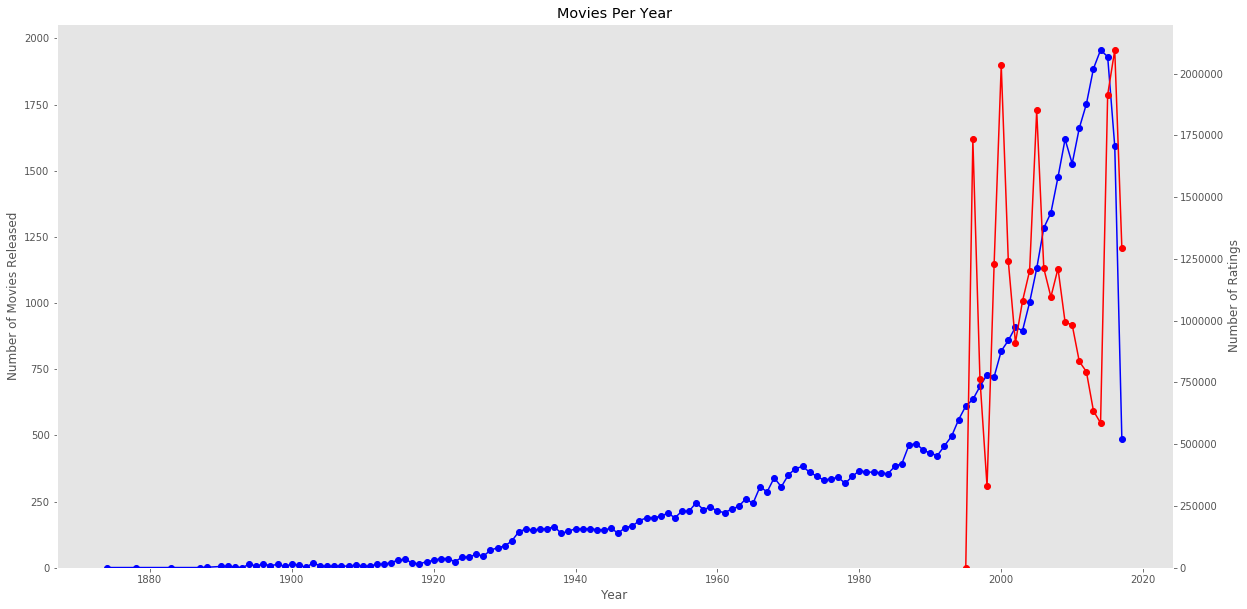

Elapsed time(sec):  1.77


In [4]:
## Number of Movies and Ratings per year. 

st = default_timer()

##### Creating dataframe for number of movies per year
dftmp = movies[['movieId', 'year']].groupby('year')

##### Creating the plot using subplots x-axis and left y-axis
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique() , "b-o")
ax1.grid(None)
ax1.set_ylim(0,)

##### Creating dataframe for number of ratings per year
dftmp = ratings[['rating', 'timestamp']].groupby('timestamp')

##### Creating the plot using subplots on x-axis and right y-axis
ax2 = ax1.twinx()
ax2.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

##### Setting labels for Title, X-Axis & Y-Axis
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Movies Released'); ax2.set_ylabel('Number of Ratings')
plt.title('Movies Per Year')
plt.show()

##### Capturing and printing the runtime for the cell
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

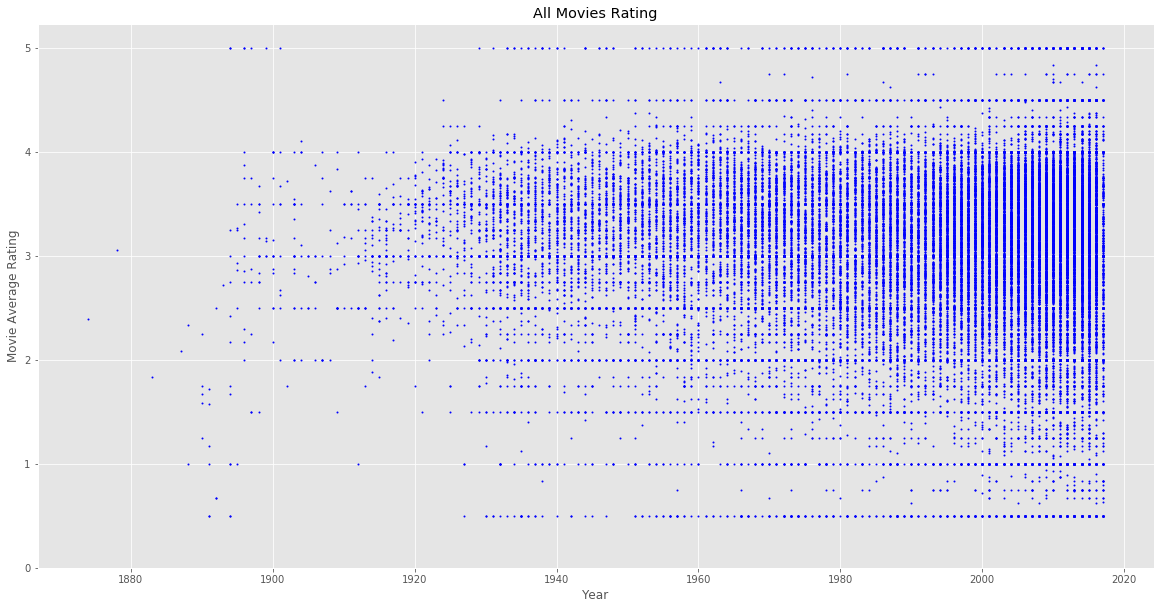

Elapsed time(sec):  1.81


In [5]:
## Average rating for all individual movies. 

##### Starting default timer for the cell
st = default_timer()

dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())

##### Plot and Setting labels for Title, X-Axis & Y-Axis
plt.figure(figsize=(20,10))
plt.plot(dftmp.year, dftmp.rating,"b.", markersize=2)
plt.xlabel('Year')
plt.ylabel('Movie Average Rating')
plt.title('All Movies Rating')
plt.ylim(0,)
plt.show()

##### Capturing and printing the runtime for the cell
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

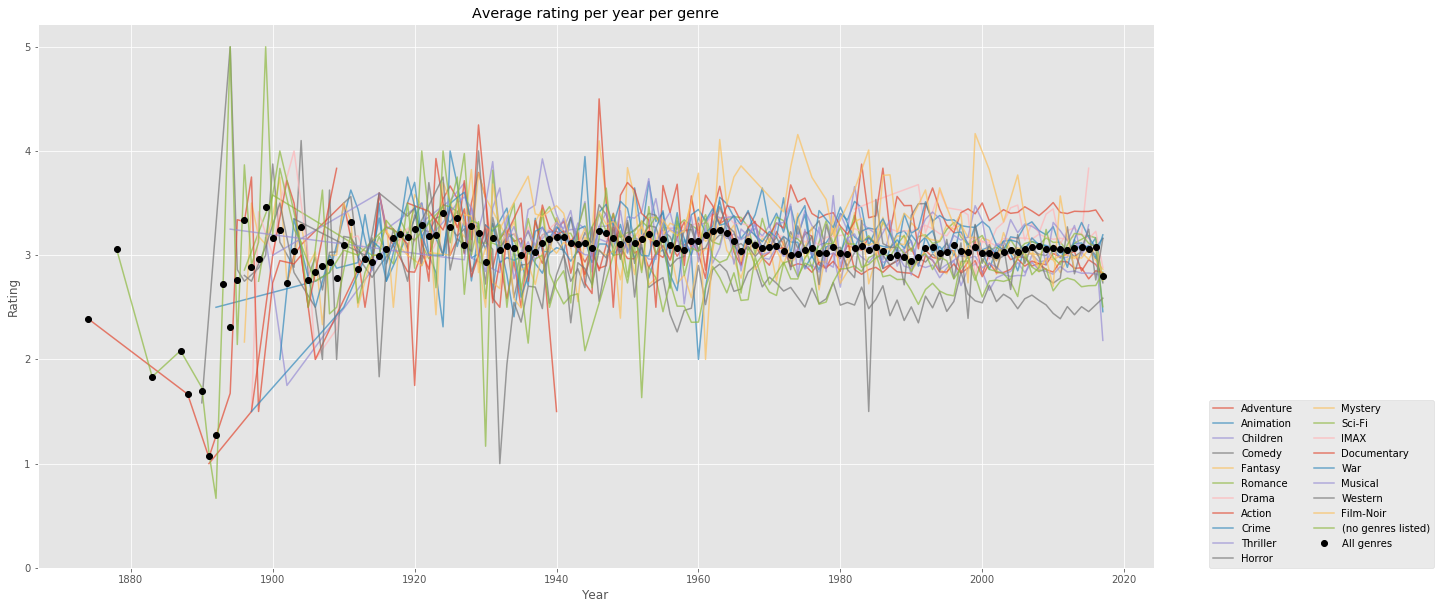

Elapsed time(sec):  66.95


In [6]:
## Average rating for all movies in each year, and also per genre. 

##### Starting default timer for the cell
st = default_timer()

plt.figure(figsize=(20,10))
##### For each genre
for genre in genres_unique.genre:
    
##### Select only movies matching current genre. Pick only movieId (as index) and year.
    dftmp = movies[movies[genre]==True][['movieId', 'year']].set_index('movieId')
    
##### Selects ratings, with movieId as index. Select only movies that match also the previous step. Join both.
    dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                       .groupby('movieId').mean())
    
##### Now we have a df of movieId, year and multiple ratings. Group by year and compute the average rating.
    dftmp = dftmp.groupby('year').mean()
    plt.plot(dftmp, label = genre, alpha=0.7)

##### For all genres
dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "o", label='All genres', color='black')

plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average rating per year per genre')
plt.legend(loc=(1.05,0), ncol=2)
plt.ylim(0,)
plt.show()

##### Capturing and printing the runtime for the cell
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

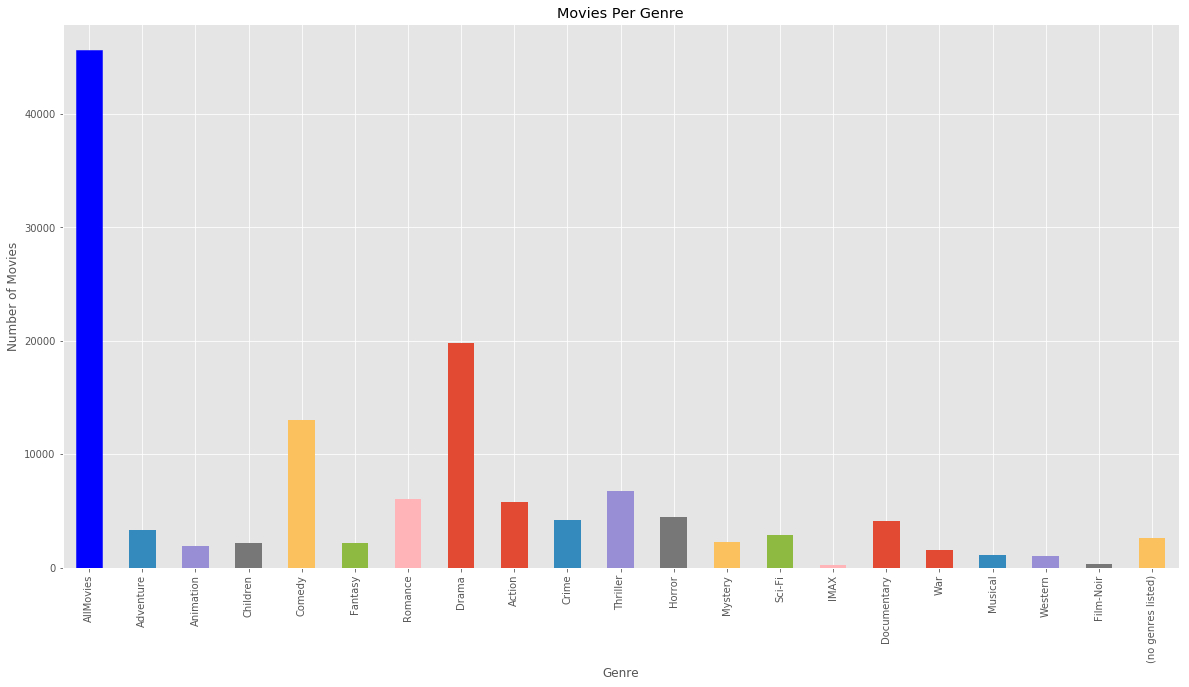

Elapsed time(sec):  0.35


In [7]:
## Popular Movie genres and Number of movies by genre in the dataset

##### Setting default timer for the cell
st = default_timer()

##### Grouping all the movies by the year
dftmp = movies[['movieId', 'year']].groupby('year')

##### AllMovies dataframe
df = pd.DataFrame({'AllMovies' : dftmp.movieId.nunique().cumsum()})

##### Plot histogram for each individual genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dftmp.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)

##### Plot barchart for number of movies by genre
plt.figure(figsize=(20,10))
barlist = df.iloc[-1].plot.bar()

##### Color 'AllMovies' differently, as it's not a genre tag count
barlist.patches[0].set_color('b') 

##### Setting labels for Title, X-Axis & Y-Axis
plt.title('Movies Per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.show()


##### Capturing and printing the runtime for the cell
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))
